In [2]:
import os
import scipy.io
from scipy.stats import ranksums
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
from learned_tuning.learned_tuning import calculate_learned_tuning_PBE_subsets, calculate_place_field_fidelity_of_learned_tuning

%matplotlib widget



data_dir = r'/home/kouroshmaboudi/Documents/Learned_tuning_Python/Datasets'
sessions = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

# included_session_IDX = [x for x in range(17) if x not in (9, 10)]
included_session_IDX = [0]

sessions = [sessions[i] for i in included_session_IDX]

for session_name in sessions:

    print(session_name)

    session_dataset_path = os.path.join(data_dir, session_name)


    #--------------------------------------------------------------------------------------------
    # Load epochs information

    filename = f'{session_name}.fileInfo_for_python.mat'
    file_path = os.path.join(session_dataset_path, filename)

    mat_file = scipy.io.loadmat(file_path)
    session_info = mat_file["fileInfo"]

    epochs = session_info["behavior"][0][0][0][0]["time"]

    epoch_names = ['PRE', 'MAZE', 'POST']
   
    
    #---------------------------------------------------------------------------------------------
    # Brain state detection results

    filename = f'{session_name}.brainStateDetection_HMMtheta_EMG_SWS_SchmidtTrigger.mat'
    file_path = os.path.join(session_dataset_path, filename)

    mat_file = scipy.io.loadmat(file_path)
    brainStates_bouts_label = mat_file['brainState']['bouts'][0][0][:, :-1]
    bouts_start_end = brainStates_bouts_label[:, :-1]/3600
    bout_labels = brainStates_bouts_label[:, -1].astype(int)

    brainStates_names = []
    for i in range(4):
        brainStates_names.append(mat_file['brainState']['names'][0][0][i][0][0])



    # --- from Bapun detection results to confirm 

    # filename = f'{session_name}.brainstates.npy'
    # file_path = os.path.join(session_dataset_path, filename)
    # brain_states_Bapun = np.load(file_path, allow_pickle = True).item()

    # bouts_start_bapun = brain_states_Bapun['epochs']['start']/3600
    # bouts_end_bapun = brain_states_Bapun['epochs']['stop']/3600

    # bout_labels_Bapun = brain_states_Bapun['epochs']['label']

    # for i in range(bout_labels_Bapun.shape[0]):
    #     if bout_labels_Bapun[i] == 'NREM':
    #         bout_labels_Bapun[i] = 1
    #     elif bout_labels_Bapun[i] == 'REM':
    #         bout_labels_Bapun[i] = 2
    #     elif bout_labels_Bapun[i] == 'AW':
    #         bout_labels_Bapun[i] = 3
    #     elif bout_labels_Bapun[i] == 'QW':
    #         bout_labels_Bapun[i] = 4



     #----------------------------------------------------------------------------------------------
    # Load spike data

    filename = f'{session_name}.spikes_for_python.mat'
    file_path = os.path.join(session_dataset_path, filename)

    mat_file = scipy.io.loadmat(file_path)
    spikes_pyr = mat_file["spikes_pyr"]

    #### Extracting all place fields from the imported .mat file
    spatial_tuning_smoothed = spikes_pyr["spatialTuning_smoothed"]

    num_units    = spatial_tuning_smoothed[0].shape[0]
    # num_units    = spatial_tuning_smoothed.shape[0] # for RatN only

    num_pos_bins = spatial_tuning_smoothed[0][0]['uni'][0][0].size

    # print(num_units, num_pos_bins)

    spikes = []; # spike data and place field info of each unit

    # attributes = list(spikes_pyr.dtype.names) % if we want to work on all variable in the imported .mat data structure
    running_directions = {'LR', 'RL', 'uni'}
    other_attributes   = {'spike_times', 'shank_id','cluster_id'}

    iter = 0
    for unit in range(num_units):
        
        # Create dictionaries for each unit and store the matrices
        
        unit_spikes = dict()
        
        unit_spikes['place_fields']  = {}
        unit_spikes['peak_pos_bins'] = {}

        
        for direction in running_directions:
            try:
                unit_spikes['place_fields'][direction] = spatial_tuning_smoothed[0][unit][direction][0][0].reshape(num_pos_bins) 
                unit_spikes['peak_pos_bins'][direction] = spikes_pyr['peakPosBin'][0][unit][direction][0][0][0][0]

                # unit_spikes['place_fields'][direction] = spatial_tuning_smoothed[unit][0][direction][0][0].reshape(num_pos_bins) 
                # unit_spikes['peak_pos_bins'][direction] = spikes_pyr['peakPosBin'][unit][0][direction][0][0][0][0]
            except ValueError:
                if iter == 0:
                    print("This session has only one running direction")
                iter += 1


        unit_spikes['spike_times'] = spikes_pyr['time'][0][unit]
        unit_spikes['shank_id']    = spikes_pyr['id'][0][unit][0][0]
        unit_spikes['cluster_id']  = spikes_pyr['id'][0][unit][0][1]

        # unit_spikes['spike_times'] = spikes_pyr['time'][unit][0] # for RatN and RatS
        # unit_spikes['shank_id']    = spikes_pyr['id'][unit][0][0][0]
        # unit_spikes['cluster_id']  = spikes_pyr['id'][unit][0][0][1]
        
            
        spikes.append(unit_spikes) 

    # place fields by pooling spikes across both running directions
    place_fields_uni = []
    for unit in range(num_units):
        place_fields_uni.append(spikes[unit]['place_fields']['uni'])
    place_fields_uni = np.array(place_fields_uni)

    place_fields_uni[place_fields_uni == 0] = 1e-4



    # --------------------------------------------------------------------------------------------
    # Load cluster quality data (L-ratios)
    
    filename = f'{session_name}.clusterQuality.mat'
    file_path = os.path.join(session_dataset_path, filename)

    mat_file = scipy.io.loadmat(file_path)

    # Access data structure
    num_shanks = len(mat_file["clusterQuality"]["Lratio"][0])

    L_ratios = list()
    for shank in range(num_shanks):    
        curr_shank_L_ratios = dict()
        curr_shank_L_ratios["L_ratios"] = mat_file["clusterQuality"]["Lratio"][0][shank]
        curr_shank_L_ratios["cluster_ids"] = mat_file["clusterQuality"]["clus"][0][shank]
        
        L_ratios.append(curr_shank_L_ratios)
    # L_ratios = []


    #-------------------------------------------------------------------------------------------------
    # Population Burst Events (PBEs)

    filename = f'{session_name}.PBEInfo_replayScores.mat'
    # filename = f'{session_name}.PBEInfo.mat'


    file_path = os.path.join(session_dataset_path, filename)
    f = h5py.File(file_path, "r")

    PBEInfo = f['PBEInfo_replayScores']
    # PBEInfo = f['PBEInfo_Bayesian']



    # Store the population burst events in an object easy to work with in Python 
    PBEs = []
    num_PBEs = PBEInfo["fr_1msbin"].shape[0]
    attributes = list(PBEInfo.keys())

    # Loop over the PBEs and create a dictionary for each one
    num_dots = int(num_PBEs * 0.1)

    count = 0
    for pbe in range(num_PBEs): #   
        # Create a dictionary for the PBE and store the matrices
        PBE_dict = {}
        for attr in attributes:
            ref = PBEInfo[attr][pbe][0]
            obj = f[ref] 
            PBE_dict[attr] = np.array(obj) 

        PBEs.append(PBE_dict)

        if (pbe+1) % num_dots == 1:
            count += 1
            message = "Importing PBEs" + "." * count
            print(message, end="\r")

    print("All PBEs were imported")


    #----------------------------------------------------------------------------------------------------
    # Import results of learned tuning calculation in MALAB

    # Load .mat file
    filename = f'{session_name}.assemblyTunings_allPBEs_Lthresh1e_3.mat'
    file_path = os.path.join(session_dataset_path, filename)

    mat_file = scipy.io.loadmat(file_path)

    active_units = dict()

    active_units["pre"] = mat_file["activeUnits"]["pre"][0][0]
    active_units["maze"] = mat_file["activeUnits"]["run"][0][0]
    active_units["post"] = mat_file["activeUnits"]["post"][0][0]

    active_units_epochs_intersect = np.intersect1d(np.intersect1d(active_units["pre"], active_units["post"]), active_units["maze"])
    active_units_epochs_intersect = active_units_epochs_intersect - 1 # to make the indices compatible with the python indexing


    #------------------------------------------------------------------------------------------------------
    # Learned tunings during Non-REM versus Quiet Wake ripples


    # The frequency of PBEs ocurring during NREM ('N') or quiet wake ('W')

    num_PBEs = len(PBEs)
    PBEs_peak_time = np.zeros((num_PBEs, 1))
    brain_state_first_letter = np.empty((num_PBEs, 1), dtype='str')

    for pbe in range(num_PBEs):
        PBEs_peak_time[pbe] = PBEs[pbe]["peakT"]
        brain_state_first_letter[pbe]= chr(np.concatenate(PBEs[pbe]["brainState"])[0])


    # Calculate learned tunings separately for NREM and QW PBEs and calculate thier PF fidleities
    time_win_duration = 900 # 15 minutes
    step_duration = 300 # 5 minutes

    time_bin_duration=0.02
    num_PF_shuffles = 10000
    learned_tunings_vs_time_NREM_vs_QW = {}  # create an empty dictionary to store the results
    



    for epoch_idx, epoch in enumerate(epoch_names):
            
        epoch_duration = epochs[epoch_idx,1] - epochs[epoch_idx,0]
            
        # PBEs for the current epoch
        if_inside_epoch = (PBEs_peak_time >= epochs[epoch_idx,0]) & (PBEs_peak_time <= epochs[epoch_idx,0]+epoch_duration)


        # NREM PBEs
        select_IDX_NREM = np.where(np.logical_and(if_inside_epoch, brain_state_first_letter == 'N'))[0]
        epoch_NREM_PBEs = np.take(PBEs, select_IDX_NREM)
        PBEs_peak_time_NREM = PBEs_peak_time[select_IDX_NREM]
        num_PBEs_NREM = len(epoch_NREM_PBEs)

        # QW PBEs
        select_IDX_QW = np.where(np.logical_and(if_inside_epoch, brain_state_first_letter == 'Q'))[0]
        epoch_QW_PBEs = np.take(PBEs, select_IDX_QW)
        PBEs_peak_time_QW = PBEs_peak_time[select_IDX_QW]
        num_PBEs_QW = len(epoch_QW_PBEs)


        # learned tunings across time

        num_time_wins = np.floor((epoch_duration-time_win_duration)/step_duration).astype(int)

            
        if epoch_idx == 0: # if PRE, aligns the last time window with MAZE start and go backward in time for definition of the earlier time windows 
            win_end_times = epochs[epoch_idx, 1] - np.arange(num_time_wins)*step_duration
            win_start_times = win_end_times - time_win_duration
        else: # if MAZE or POST, alighn the first time bin with MAZE
            win_start_times = epochs[epoch_idx, 0] + np.arange(num_time_wins)*step_duration
            win_end_times = win_start_times + time_win_duration
        win_centers = win_start_times + time_win_duration/2



        # sorting the windows chronologically 
        sort_indices = np.argsort(win_centers)

        win_centers = win_centers[sort_indices]
        win_start_times = win_start_times[sort_indices]
        win_end_times = win_end_times[sort_indices]


        PBEs_indices_per_win_NREM = [None for _ in range(num_time_wins)]
        num_PBEs_per_win_NREM = []
        PBEs_indices_per_win_QW = [None for _ in range(num_time_wins)]
        num_PBEs_per_win_QW = []

        for win in range(num_time_wins):

            PBEs_indices_per_win_NREM[win] = np.where((PBEs_peak_time_NREM >= win_start_times[win]) & (PBEs_peak_time_NREM <= win_end_times[win]))[0]
            num_PBEs_per_win_NREM.append(len(PBEs_indices_per_win_NREM[win]))

            PBEs_indices_per_win_QW[win] = np.where((PBEs_peak_time_QW >= win_start_times[win]) & (PBEs_peak_time_QW <= win_end_times[win]))[0]
            num_PBEs_per_win_QW.append(len(PBEs_indices_per_win_QW[win]))




        # NREM #################

        # initialize the objects
        learned_tunings_NREM_across_time = np.full((num_units, num_pos_bins, num_time_wins), np.nan)
        learned_tuning_place_field_pearson_corr_NREM_across_time = np.full((num_units, num_time_wins), np.nan)
        median_LT_PF_pearson_corr_NREM_across_time = [None for _ in range(num_time_wins)]

        if len(epoch_NREM_PBEs) > 0: # especially for MAZE period we know that there are usually no PBEs present
            
            # Calculate the learned tunings
            print(f"calculating learned tunings using NREM PBEs in {epoch}")
            learned_tunings_NREM_across_time = calculate_learned_tuning_PBE_subsets(epoch_NREM_PBEs, spikes, PBEs_indices_per_win_NREM, L_ratios, time_bin_duration)

            # Calculate the PF fidelity of the NREM learned tunings
            for win in range(num_time_wins):
                learned_tuning_place_field_pearson_corr_NREM_across_time[active_units_epochs_intersect, win], median_LT_PF_pearson_corr_NREM_across_time[win] = calculate_place_field_fidelity_of_learned_tuning(
                    learned_tunings_NREM_across_time[active_units_epochs_intersect, :, win], 
                    place_fields_uni[active_units_epochs_intersect, :], 
                    num_PF_shuffles)




        # QW ###################

        # initialize the objects
        learned_tunings_QW_across_time = np.full((num_units, num_pos_bins, num_time_wins), np.nan)
        learned_tuning_place_field_pearson_corr_QW_across_time = np.full((num_units, num_time_wins), np.nan)
        median_LT_PF_pearson_corr_QW_across_time = [None for _ in range(num_time_wins)]

        if len(epoch_QW_PBEs) > 0:

            # Calculate the learned tunings
            print(f"calculating learned tunings using QW PBEs in {epoch}")
            learned_tunings_QW_across_time = calculate_learned_tuning_PBE_subsets(epoch_QW_PBEs, spikes, PBEs_indices_per_win_QW, L_ratios, time_bin_duration)
            
            # Calculate the PF fidelity of the QW learned tunings
            for win in range(num_time_wins):
                learned_tuning_place_field_pearson_corr_QW_across_time[active_units_epochs_intersect, win], median_LT_PF_pearson_corr_QW_across_time[win] = calculate_place_field_fidelity_of_learned_tuning(
                    learned_tunings_QW_across_time[active_units_epochs_intersect, :, win], 
                    place_fields_uni[active_units_epochs_intersect, :], 
                    num_PF_shuffles)


        # Store the results
        learned_tunings_vs_time_NREM_vs_QW[epoch] = {
            'learned_tunings_NREM_across_time': learned_tunings_NREM_across_time,
            'learned_tuning_place_field_pearson_corr_NREM_across_time': learned_tuning_place_field_pearson_corr_NREM_across_time,
            'median_LT_PF_pearson_corr_NREM_across_time': median_LT_PF_pearson_corr_NREM_across_time,
            'num_PBEs_per_win_NREM':num_PBEs_per_win_NREM,
            'learned_tunings_QW_across_time': learned_tunings_QW_across_time,
            'learned_tuning_place_field_pearson_corr_QW_across_time': learned_tuning_place_field_pearson_corr_QW_across_time,
            'median_LT_PF_pearson_corr_QW_across_time': median_LT_PF_pearson_corr_QW_across_time,
            'num_PBEs_per_win_QW':num_PBEs_per_win_QW,
            'win_centers': win_centers
        }


    filename = f'{session_name}.learned_tunings_vs_time_NREM_vs_QW.npy'
    file_path = os.path.join(session_dataset_path, filename)
    np.save(file_path, learned_tunings_vs_time_NREM_vs_QW)
                                        

In [10]:
# Loading the previously calculated and stored results

data_dir = r'/home/kouroshmaboudi/Documents/Learned_tuning_Python/Datasets'
session_name = 'RatU_Day2NSD_2021-07-24_08-16-38'
session_dataset_path = os.path.join(data_dir, session_name)


filename = f'{session_name}.fileInfo_for_python.mat'
file_path = os.path.join(session_dataset_path, filename)

mat_file = scipy.io.loadmat(file_path)
session_info = mat_file["fileInfo"]

epochs = session_info["behavior"][0][0][0][0]["time"]

epoch_names = ['PRE', 'MAZE', 'POST']


filename = f'{session_name}.brainStateDetection_HMMtheta_EMG_SWS_SchmidtTrigger.mat'
file_path = os.path.join(session_dataset_path, filename)

mat_file = scipy.io.loadmat(file_path)
brainStates_bouts_label = mat_file['brainState']['bouts'][0][0][:, :-1]
bouts_start_end = brainStates_bouts_label[:, :-1]/3600
bout_labels = brainStates_bouts_label[:, -1].astype(int)

brainStates_names = []
for i in range(4):
    brainStates_names.append(mat_file['brainState']['names'][0][0][i][0][0])


In [11]:
# The learned tunings based on 4+ hours data

session_dataset_path = os.path.join(data_dir, session_name)

filename = f'{session_name}.learned_tunings_vs_time_NREM_vs_QW.npy'
file_path = os.path.join(session_dataset_path, filename)
learned_tunings_vs_time_NREM_vs_QW = np.load(file_path, allow_pickle = True).item()

filename = f'{session_name}.learned_tunings_NREM_vs_QW.npy'
file_path = os.path.join(session_dataset_path, filename)
learned_tunings_NREM_vs_QW = np.load(file_path, allow_pickle = True).item()

/tmp/ipykernel_53505/3931087694.py:11: RuntimeWarning: invalid value encountered in divide
  normalized_matrix = matrix / col_max[np.newaxis, :]


NameError: name 'num_pos_bins' is not defined

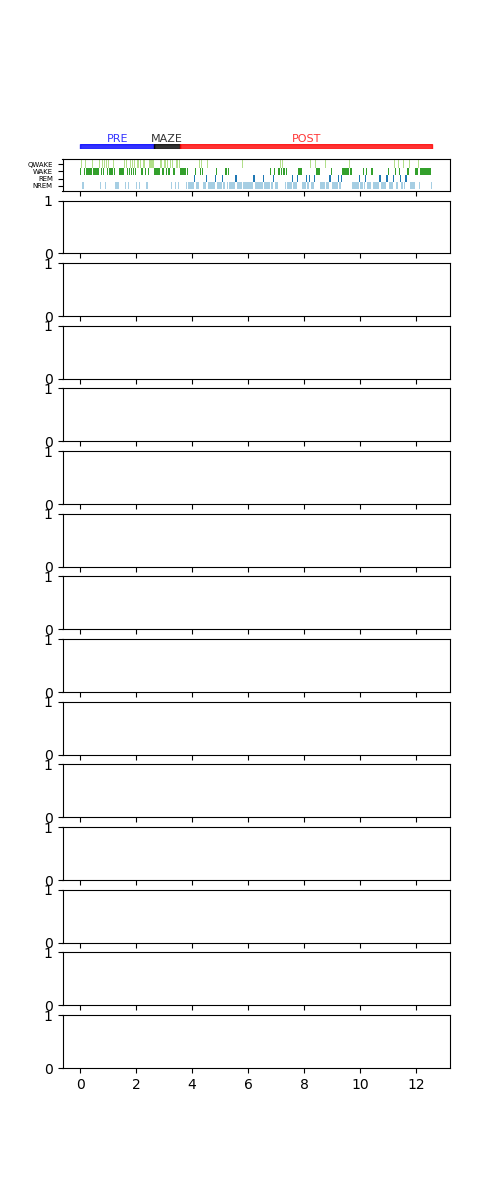

In [12]:
# Modifying the cell above but shoeing the NREM and QW learned tunings of the neurons next to each other

def max_normalize_columns(matrix):
    """
    Takes a matrix as input and returns a new matrix where each column sums up to one (a probability distribution)
    """
    # calculate the sum of each column
    col_max = np.max(matrix, axis=0)
    
    # divide each element in a column by its sum
    normalized_matrix = matrix / col_max[np.newaxis, :]
    
    return normalized_matrix


# There is a mismatch between the unit indices in the bulk (4 hours version) and time-resolved (time windows) learned tunings. In the bulk version the unit identities correspond to active units
# while in the time-window version, all units are present. To resolve the mismatch we need to calcualte the active units again.

filename = f'{session_name}.assemblyTunings_allPBEs_Lthresh1e_3.mat'
file_path = os.path.join(session_dataset_path, filename)
mat_file = scipy.io.loadmat(file_path)

active_units = dict()
active_units["pre"] = mat_file["activeUnits"]["pre"][0][0]
active_units["maze"] = mat_file["activeUnits"]["run"][0][0]
active_units["post"] = mat_file["activeUnits"]["post"][0][0]

active_units_epochs_intersect = np.intersect1d(np.intersect1d(active_units["pre"], active_units["post"]), active_units["maze"])
active_units_epochs_intersect = active_units_epochs_intersect - 1 # to make the indices compatible with the python indexing



# Plotting the learned across time 

# Choosing units with maximum PF fidelity
learned_tuning_place_field_pearson_corr_NREM = learned_tunings_NREM_vs_QW['POST']['learned_tuning_place_field_pearson_corr_NREM']

unit_sort_IDX = np.argsort(learned_tuning_place_field_pearson_corr_NREM)
units_t_plot = unit_sort_IDX[-15:-1]


learned_tunings_vs_time_active_units = dict()
for epoch in epoch_names:
    learned_tunings_vs_time_active_units[epoch] = dict()
    learned_tunings_vs_time_active_units[epoch]['NREM'] = learned_tunings_vs_time_NREM_vs_QW[epoch]['learned_tunings_NREM_across_time'][active_units_epochs_intersect]
    learned_tunings_vs_time_active_units[epoch]['QW'] = learned_tunings_vs_time_NREM_vs_QW[epoch]['learned_tunings_QW_across_time'][active_units_epochs_intersect]

num_pos_bins = learned_tunings_vs_time_active_units[epoch]['NREM'].shape[0]


# num_units, num_pos_bins, _ = learned_tunings_vs_time_NREM_vs_QW_active_units_POST.shape
win_centers_POST = learned_tunings_vs_time_NREM_vs_QW['POST']['win_centers']
win_centers_POST = win_centers_POST/3600

win_centers_PRE = learned_tunings_vs_time_NREM_vs_QW['PRE']['win_centers']
win_centers_PRE = win_centers_PRE/3600


# median_LT_PF_corr = []
# for win in range(win_centers.shape[0]):
#     median_LT_PF_corr.append(learned_tunings_vs_time_NREM_vs_QW['POST']['median_LT_PF_pearson_corr_NREM_across_time'][win]["data"])


fig, axes = plt.subplots(units_t_plot.shape[0]+2,1, sharex=True, gridspec_kw = {'height_ratios':[.1, .6]+[1]*units_t_plot.shape[0], 'width_ratios': [1]}) 
fig.set_size_inches(5,12) 
plt.style.context('dark_background')

epochs_hours = epochs/3600

# plot epoch indicator bars
colors=['blue','black','red']
for i, epoch in enumerate(epoch_names):
    start,end = epochs_hours[i]
    axes[0].axvspan(start, end, alpha=0.8, color=colors[i])
    axes[0].text(np.mean(epochs_hours[i]), 1.3, epoch, fontsize=8, ha='center', color=colors[i], alpha=0.8)
axes[0].axis('off')


# plot brain state indicator bar
colors = sns.color_palette('Paired', n_colors=4)
colors = [colors[0], colors[1], colors[3], colors[2]]

for bout_idx in range(bout_labels.shape[0]):
    axes[1].barh(y = bout_labels[bout_idx], left=bouts_start_end[bout_idx, 0], width = bouts_start_end[bout_idx,1]-bouts_start_end[bout_idx,0], height=1, color=colors[bout_labels[bout_idx]-1]) #
# axes[1].axis('off')
axes[1].set_yticks([1,2,3,4],  brainStates_names)
axes[1].tick_params(axis='both', which='major', labelsize=5)


# # plot brain states based on Bapun's calculations
# for bout_idx in range(bout_labels_Bapun.shape[0]):
#     axes[2].barh(y = bout_labels_Bapun[bout_idx], left=bouts_start_bapun[bout_idx], width = bouts_end_bapun[bout_idx]-bouts_start_bapun[bout_idx], height=1, color=colors[bout_labels_Bapun[bout_idx]-1]) #
# # axes[1].axis('off')
# axes[2].set_yticks([1,2,3,4],  brainStates_names)
# axes[2].tick_params(axis='both', which='major', labelsize=5)

 

# plot the learned tunings for the example units
start_idx = 2
for i, curr_unit in enumerate(units_t_plot):

    for j, epoch in enumerate(epoch_names):

        NREM_LT = learned_tunings_vs_time_active_units[epoch]['NREM'][curr_unit, :, :]
        NREM_LT = max_normalize_columns(NREM_LT)

        QW_LT = learned_tunings_vs_time_active_units[epoch]['QW'][curr_unit, :, :]
        QW_LT = max_normalize_columns(QW_LT)

        LT = np.concatenate([QW_LT, NREM_LT], axis=0) # concatenate the NREM and QW learned tunings along position dimension in order to plot them together

        axes[i+start_idx].imshow(LT, extent = [epochs_hours[j, 0], epochs_hours[j, 1], 0, num_pos_bins*2], interpolation='nearest', origin = 'lower', cmap='viridis', label=epoch) 

    axes[i+start_idx].set_xlim([win_centers_PRE[0], win_centers_POST[-1]])
    axes[i+start_idx].set_title(f"unit {curr_unit}", loc = 'left', fontsize= 8)
    axes[i+start_idx].set_aspect("auto")
    axes[i+start_idx].tick_params(axis='both', which='major', labelsize=6)
    axes[i+start_idx].axhline(y = num_pos_bins, color='white', linestyle='--', linewidth=0.5)
    axes[i+start_idx].axvline(x = epochs_hours[1, 0], color='gray', linestyle='-', linewidth=0.5)
    axes[i+start_idx].axvline(x = epochs_hours[1, 1], color='gray', linestyle='-', linewidth=0.5)

    if i == 0:
        axes[i+start_idx].text(-1.5, 0.4*num_pos_bins, 'QW:', fontsize=8, ha = 'left', color='black', alpha = 0.8)
        axes[i+start_idx].text(-1.5, 1.4*num_pos_bins, 'NREM:', fontsize=8, ha = 'left', color='black', alpha = 0.8)
    
    axes[i+start_idx].set_yticks([0, num_pos_bins, num_pos_bins*2], [0, '0\n1', 1])
    axes[i+start_idx].set_ylabel('position', fontsize=6)


plt.subplots_adjust(hspace=0.5)
# plt.tight_layout()

filename = f'{session_name}.QW_NREM_learned_tuning_vs_time.svg'
file_path = os.path.join(session_dataset_path, filename)
plt.savefig(file_path, dpi=300)

plt.show()

In [6]:
epoch_names = ['PRE', 'MAZE', 'POST']